# ImfitDummy

Minimal image fitting program for testing things

## Function definitions

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from lib.imageRead import readImage
from lib.imageProcess import calcOD as calcOD_class

In [35]:
def load_image(mode, path):
    reader = readImage(mode, path)
    reader.updateAll()
    return {"metadata": reader.metadata, "data": reader.frames, "file": reader, "mode": mode}

def calc_OD(image, species, region):
    return calcOD_class(image["file"], species, image["mode"], region).ODCorrected

## Sample script

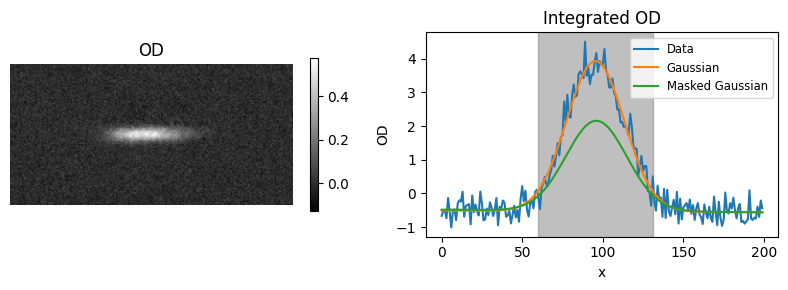

In [72]:
from lib.imfitFunctions import gaussian1D
from scipy.optimize import least_squares

mode = "Side iXon Molecules ToF"
path = "K:/data/2024/11/20241114/MoleculeInSituFK/ixon_85.npz"
species = "|0,0>"
region = [229, 330, 200, 100] # [x, y, width, height]

img = load_image(mode, path)
OD = calc_OD(img, species, region)
integrated_OD = np.sum(OD, axis=0)

# 1D Gaussian args: p, x, y
# 1D Gaussian parameters: [offset, amplitude, x0, sigma, gradient]
bg = np.quantile(integrated_OD, 0.1)
size = np.std(integrated_OD - bg)
p0 = [bg, np.max(integrated_OD) - bg, np.argmax(integrated_OD), size, 0]
xs = np.arange(len(integrated_OD))
res_gauss = least_squares(gaussian1D, p0, args=(xs, integrated_OD))
fit_gauss = gaussian1D(res_gauss.x, xs, np.zeros_like(xs))

# 1D Gaussian fit with masked central region
mask_size = 2 # sigma
mask = np.abs(xs - res_gauss.x[2]) > mask_size * res_gauss.x[3]
fit_func = lambda p, x, y: gaussian1D(p, x, y) * mask
res_gauss_masked = least_squares(fit_func, res_gauss.x, args=(xs, integrated_OD))
fit_gauss_masked = gaussian1D(res_gauss_masked.x, xs, np.zeros_like(xs))

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plt.colorbar(axs[0].imshow(OD, cmap="gray"), ax=axs[0], shrink=0.75)
axs[0].set_title("OD")
axs[0].axis("off")

axs[1].axvspan(res_gauss.x[2] - mask_size * res_gauss.x[3], res_gauss.x[2] + mask_size * res_gauss.x[3], color="gray", alpha=0.5)
axs[1].plot(integrated_OD, label="Data")
axs[1].plot(fit_gauss, label="Gaussian")
axs[1].plot(fit_gauss_masked, label="Masked Gaussian")
axs[1].set_title("Integrated OD")
axs[1].set_xlabel("x")
axs[1].set_ylabel("OD")
axs[1].legend(fontsize="small")

plt.tight_layout()
plt.show()